# **COVID-19 Data Analysis Assignment**

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pycountry

# Data Inspection

In [2]:
df = pd.read_csv("WHO-COVID-19-global-daily-data.csv")


print("\n--- Dataset Shape ---")
print(df.shape)
print("\n--- Dataset Info ---")
print(df.info())
print("\n--- First Rows ---")
df.head()


--- Dataset Shape ---
(489360, 8)

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489360 entries, 0 to 489359
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date_reported      489360 non-null  object 
 1   Country_code       487321 non-null  object 
 2   Country            489360 non-null  object 
 3   WHO_region         489360 non-null  object 
 4   New_cases          210338 non-null  float64
 5   Cumulative_cases   489360 non-null  int64  
 6   New_deaths         153975 non-null  float64
 7   Cumulative_deaths  489360 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 29.9+ MB
None

--- First Rows ---


,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-04,AI,Anguilla,AMR,NaN,0,NaN,0
1,2020-01-04,AZ,Azerbaijan,EUR,NaN,0,NaN,0
2,2020-01-04,BD,Bangladesh,SEAR,0.0,0,0.0,0
3,2020-01-04,BB,Barbados,AMR,NaN,0,NaN,0
4,2020-01-04,BR,Brazil,AMR,NaN,0,NaN,0


# Data Cleaning

Check for Missing Values

In [3]:
print("\n--- Missing Values ---")
print(df.isnull().sum())


--- Missing Values ---
Date_reported             0
Country_code           2039
Country                   0
WHO_region                0
New_cases            279022
Cumulative_cases          0
New_deaths           335385
Cumulative_deaths         0
dtype: int64


Map Missing Country Codes Using pycountry

In [4]:
def get_country_code(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except:
        return None

# Fill missing country_code using country names
df.loc[df['Country_code'].isnull(), 'Country_code'] = df.loc[df['Country_code'].isnull(), 'Country'].apply(get_country_code)

print("Remaining missing country_code:", df['Country_code'].isnull().sum())

Remaining missing country_code: 0


Clean and Prepare Dataset

In [5]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Convert date to datetime
df['Date_reported'] = pd.to_datetime(df['Date_reported'])

# Fill missing New_cases and New_deaths with 0 as Missing values likely mean no new cases/deaths reported
df.fillna(0, inplace=True)

df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-04,AI,Anguilla,AMR,0.0,0,0.0,0
1,2020-01-04,AZ,Azerbaijan,EUR,0.0,0,0.0,0
2,2020-01-04,BD,Bangladesh,SEAR,0.0,0,0.0,0
3,2020-01-04,BB,Barbados,AMR,0.0,0,0.0,0
4,2020-01-04,BR,Brazil,AMR,0.0,0,0.0,0


Check for Missing Values After Filling

In [6]:
print("\n--- Missing Values ---")
print(df.isnull().sum())


--- Missing Values ---
Date_reported        0
Country_code         0
Country              0
WHO_region           0
New_cases            0
Cumulative_cases     0
New_deaths           0
Cumulative_deaths    0
dtype: int64


# Feature Engineering

Add COVID-19 Mortality Rate (%)

In [7]:
df['Mortality_rate_%'] = np.where(df['Cumulative_cases'] > 0,(df['Cumulative_deaths'] / df['Cumulative_cases']) * 100,0)

df[['Country', 'Date_reported', 'Cumulative_cases', 'Cumulative_deaths', 'Mortality_rate_%']].tail(10)


,Country,Date_reported,Cumulative_cases,Cumulative_deaths,Mortality_rate_%
489350,El Salvador,2025-08-03,202017,4230,2.093883
489351,Finland,2025-08-03,1512600,11466,0.758033
489352,Iceland,2025-08-03,210956,186,0.088170
489353,Holy See,2025-08-03,26,0,0.000000
489354,Kenya,2025-08-03,344136,5689,1.653126
489355,Mali,2025-08-03,33197,743,2.238154
489356,Mauritania,2025-08-03,63891,997,1.560470
489357,Mexico,2025-08-03,7628380,335007,4.391588
489358,New Caledonia,2025-08-03,80203,314,0.391507
489359,Montenegro,2025-08-03,251280,2654,1.056192


Top 10 Countries by COVID-19 Mortality Rate

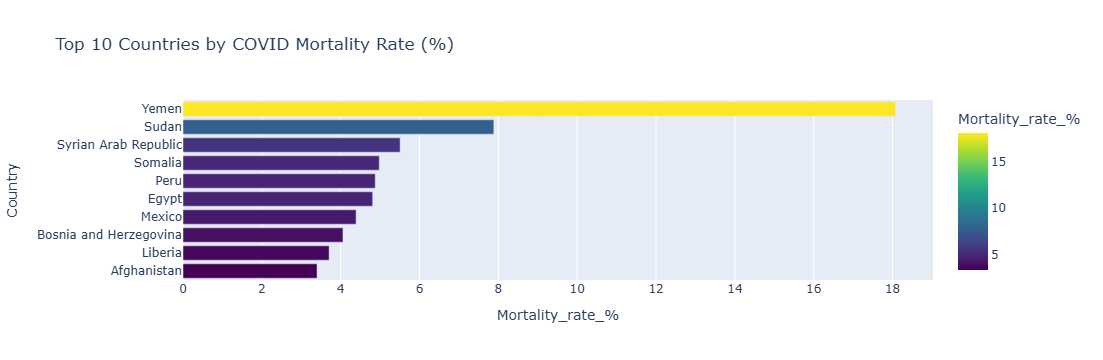

In [8]:
latest = df[df['Date_reported'] == df['Date_reported'].max()]

top_mortality = latest.sort_values(by="Mortality_rate_%", ascending=False).head(10)

fig = px.bar(
    top_mortality,
    x="Mortality_rate_%",
    y="Country",
    orientation="h",
    color="Mortality_rate_%",
    color_continuous_scale="Viridis",
    title="Top 10 Countries by COVID Mortality Rate (%)",

)
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()


**Insight**: Countries with the highest COVID mortality rates often have smaller populations or limited healthcare resources, highlighting disparities in pandemic impact.

# Univariate Analysis

Top 10 Countries by Total COVID-19 Cases

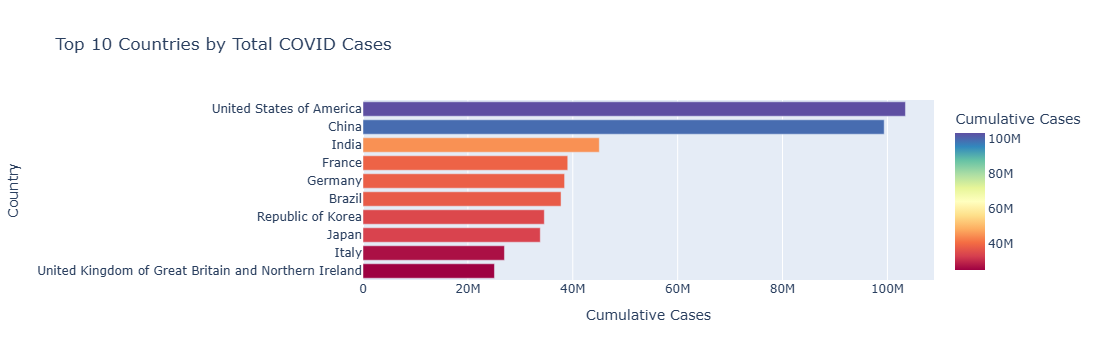

In [9]:
top_cases = (
    df.groupby("Country")['Cumulative_cases'].max().sort_values(ascending=False).head(10).reset_index())

fig = px.bar(
    top_cases,
    x="Cumulative_cases",
    y="Country",
    orientation="h",
    color="Cumulative_cases",
    color_continuous_scale="Spectral",
    title="Top 10 Countries by Total COVID Cases",
    labels={"Cumulative_cases": "Cumulative Cases"}
)

fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()


**Insight**: A few countries dominate total COVID-19 cases, indicating uneven global spread and population size influence on total counts.

# Bivariate Analysis

Daily COVID-19 Trends by WHO Region

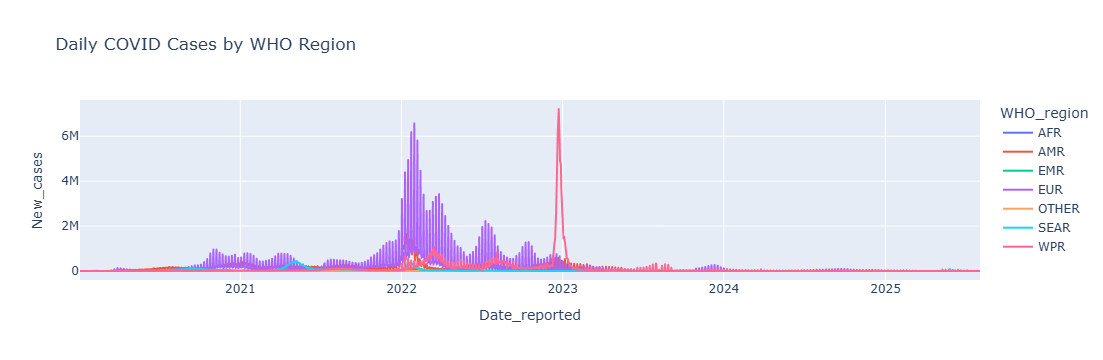

Insight: The Americas and Europe show high daily cases, while Africa and Western Pacific show lower counts with intermittent spikes.


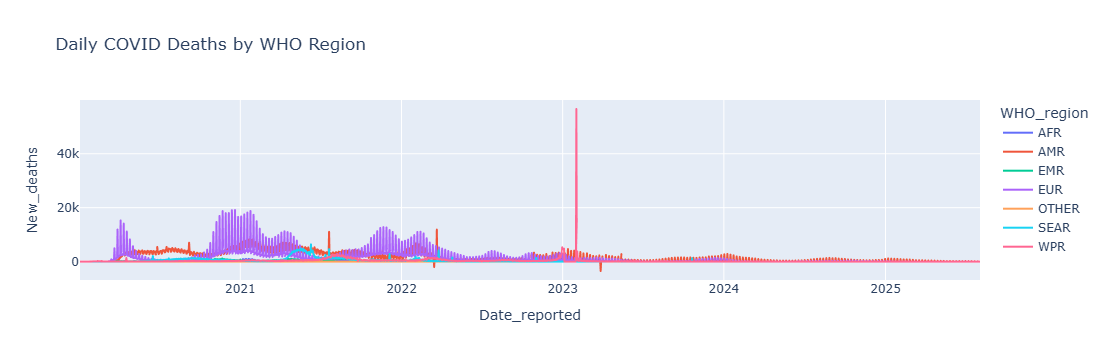

Insight: Deaths follow a similar regional pattern as cases; however, mortality trends are less volatile and highlight healthcare capacity differences.


In [10]:
region_trends = (df.groupby(["Date_reported", "WHO_region"])[["New_cases", "New_deaths"]].sum().reset_index())

# Daily cases per region
fig_cases = px.line(
    region_trends,
    x="Date_reported",
    y="New_cases",
    color="WHO_region",
    title="Daily COVID Cases by WHO Region"
)
fig_cases.show()
print("Insight: The Americas and Europe show high daily cases, while Africa and Western Pacific show lower counts with intermittent spikes.")

# Daily deaths per region
fig_deaths = px.line(
    region_trends,
    x="Date_reported",
    y="New_deaths",
    color="WHO_region",
    title="Daily COVID Deaths by WHO Region"
)
fig_deaths.show()
print("Insight: Deaths follow a similar regional pattern as cases; however, mortality trends are less volatile and highlight healthcare capacity differences.")



# Multivariate Analysis

COVID-19 Cases vs Deaths Scatter

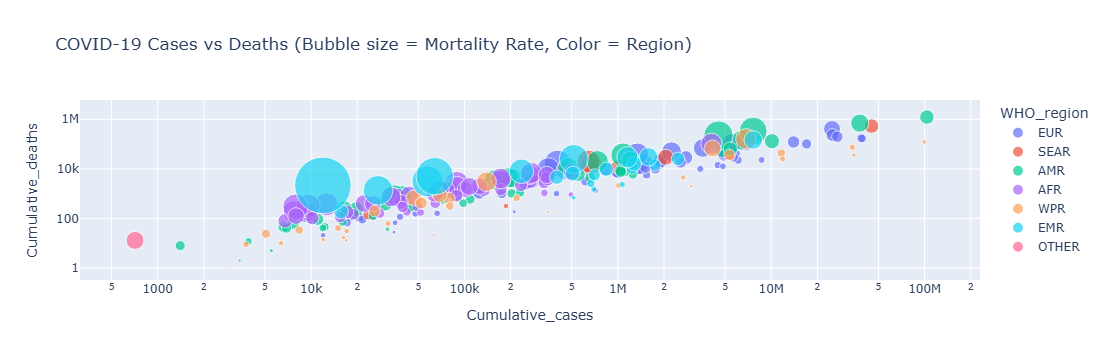

In [11]:
latest = df[df['Date_reported'] == df['Date_reported'].max()].copy()

latest = latest[latest['Mortality_rate_%'] > 0]

fig = px.scatter(
    latest,
    x="Cumulative_cases",
    y="Cumulative_deaths",
    size="Mortality_rate_%",
    color="WHO_region",
    hover_name="Country",
    size_max=40,
    log_x=True, log_y=True,
    title="COVID-19 Cases vs Deaths (Bubble size = Mortality Rate, Color = Region)"
)

fig.show()


**Insight**: Scatter plot shows clustering by region; Europe and Americas have high cases and deaths, Africa shows lower totals but higher mortality in some countries.

# Global COVID-19 Geographic Overview


Global COVID-19 Cases Map

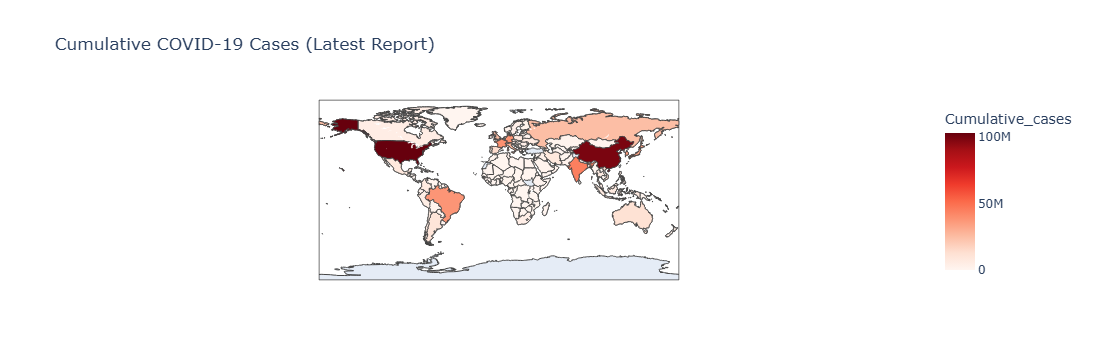

In [15]:
import warnings
warnings.filterwarnings('ignore')

latest = df[df["Date_reported"] == df["Date_reported"].max()]

fig = px.choropleth(
    latest,
    locations="Country",
    locationmode="country names",
    color="Cumulative_cases",
    hover_name="Country",
    color_continuous_scale="Reds",
    title="Cumulative COVID-19 Cases (Latest Report)"
)
fig.show()


**Insight**: Maps emphasize that total cases are influenced by population size, with large countries dominating case counts.

Global COVID-19 Mortality Rate Map

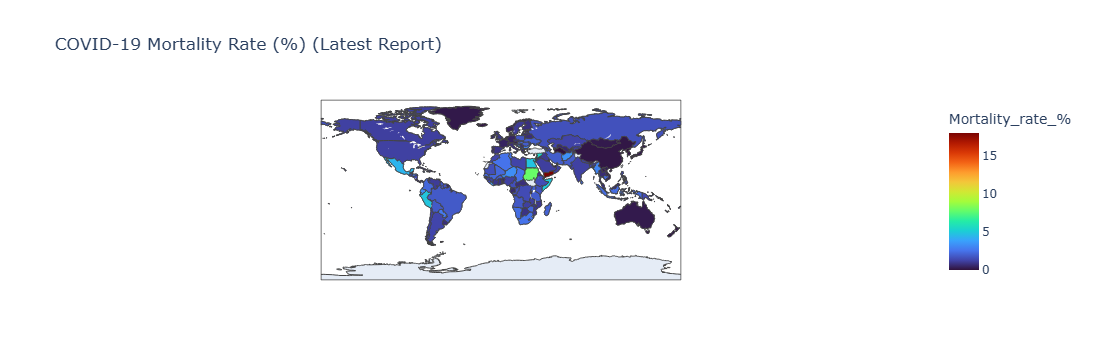

In [16]:
fig_mortality_map = px.choropleth(
    latest,
    locations="Country",
    locationmode="country names",
    color="Mortality_rate_%",   # use the feature we engineered earlier
    hover_name="Country",
    color_continuous_scale="Turbo",
    title="COVID-19 Mortality Rate (%) (Latest Report)"
)
fig_mortality_map.show()


**Insight**: Mortality rate maps normalize for population and provide a clearer comparison of COVID-19 severity across countries.

# **Final Insights**

*   COVID-19 spread globally but hit Europe and the Americas the hardest in cases and deaths.

*   Daily new cases/deaths are uneven — most countries show long periods of near-zero, while a few dominate totals.

*   Mortality rates differ sharply: some under 1%, others above 10%, reflecting testing and healthcare capacity.

*   Scatter plots show regional clusters — Europe/Americas with high cases and deaths; Africa/W. Pacific lower but with some high fatality pockets.

*   Maps highlight bias: case counts favor big populations, while mortality rates give a clearer comparison across countries.







